In [ ]:
import pandas as pd

import sys, os
sys.path.insert(0, os.path.abspath('../funs'))

%load_ext autoreload
%autoreload 2

from utils import get_merged_dataframes, chi2_independence, anova_test, spearman_correlation
from plots import plot_correlation_matrix

#### Import data and merge dataframes

In [3]:
full_data = get_merged_dataframes()

Extracting countries from coordinates...
Found 500,000 valid coordinates
Processing coordinates in batches...


  0%|          | 0/500 [00:00<?, ?it/s]

Loading formatted geocoded file...
Assigning countries to dataframe...
Countries extracted. Found 500,000 locations.


#### Basic Cleaning & Feature Engineering

In [4]:
# Missing values
full_data['education'] = full_data['education'].fillna('Missing')

# Aggregates by merchant and user
full_data['fraud_transactions_per_merchant'] = full_data.groupby('merchant_id')['is_fraud'].transform('sum')
full_data['transactions_per_merchant'] = full_data.groupby('merchant_id')['is_fraud'].transform('count')
full_data['fraud_transactions_per_user'] = full_data.groupby('user_id')['is_fraud'].transform('sum')
full_data['transactions_per_user'] = full_data.groupby('user_id')['is_fraud'].transform('count')

# Fraud ratios
full_data['fraud_ratio_per_merchant'] = (
    full_data['fraud_transactions_per_merchant'] / full_data['transactions_per_merchant']
)
full_data['fraud_ratio_per_user'] = (
    full_data['fraud_transactions_per_user'] / full_data['transactions_per_user']
)

# Timestamp -> datetime
full_data['timestamp'] = pd.to_datetime(full_data['timestamp'])
full_data['signup_date'] = pd.to_datetime(full_data['signup_date'])
full_data['hour'] = full_data['timestamp'].dt.hour
full_data['day_of_week'] = full_data['timestamp'].dt.dayofweek
full_data['days_since_signup'] = (full_data['timestamp'] - full_data['signup_date']).dt.days

# Amount avg
user_avg = full_data.groupby('user_id')['amount'].transform('mean')
full_data['amount_to_user_avg'] = full_data['amount'] / (user_avg + 1e-5)  # Avoid division by zero


# Rolling transaction count over the last 7 days
full_data = full_data.sort_values(['user_id', 'timestamp'])

def rolling_txn_count(df):
    df = df.set_index('timestamp')
    return df['transaction_id'].rolling('7d').count()

full_data['txn_count_last_7d'] = (
    full_data
    .groupby('user_id', group_keys=False)[['timestamp', 'transaction_id']]
    .apply(rolling_txn_count)
    .reset_index(drop=True)
)

full_data['is_first_ever_transaction'] = (
    full_data.groupby('user_id').cumcount() == 0
).astype(int)

# Other ratios
full_data['expense_income_ratio'] = full_data['sum_of_monthly_expenses'] / (full_data['sum_of_monthly_installments'] + 1e-5)
full_data['txn_to_expense_ratio'] = full_data['amount'] / (full_data['sum_of_monthly_expenses'] + 1e-5)

# Get transaction country counts per user
user_country_counts = full_data.groupby('user_id')['transaction_country'].nunique()

# Map back to original dataframe
full_data['unique_countries_count'] = full_data['user_id'].map(user_country_counts)

# Check if transaction is in user's most frequent country
user_most_common_country = full_data.groupby('user_id')['transaction_country'].agg(lambda x: x.value_counts().index[0])
full_data['is_common_country'] = (full_data['transaction_country'] == full_data['user_id'].map(user_most_common_country)).astype(int)

# Create feature for transactions in countries user has never transacted before
user_countries = full_data.groupby('user_id')['transaction_country'].apply(set)
full_data['is_new_country'] = full_data.apply(
    lambda row: 1 if row['transaction_country'] not in user_countries.loc[row['user_id']] - {row['transaction_country']} else 0, 
    axis=1
)

One hot encoding

In [5]:
sex_dummies       = pd.get_dummies(full_data['sex'], prefix='sex')
education_dummies = pd.get_dummies(full_data['education'], prefix='education')
income_dummies    = pd.get_dummies(full_data['primary_source_of_income'], prefix='primary_income')
category_dummies  = pd.get_dummies(full_data['category'], prefix='category')
user_country_dummies = pd.get_dummies(full_data['user_country'], prefix='user_country')
merchant_country_dummies = pd.get_dummies(full_data['merchant_country'], prefix='merchant_country')

# Merge all dummies
full_data = pd.concat([
    full_data.drop(['category', 'user_country', 'merchant_country'], axis=1),
    sex_dummies,
    education_dummies,
    income_dummies,
    category_dummies,
    user_country_dummies,
    merchant_country_dummies
], axis=1)

for col in ['channel', 'device', 'payment_method', 'education']:
    freq = full_data[col].value_counts(normalize=True)
    full_data[f'{col}_freq'] = full_data[col].map(freq)

In [52]:
full_data.columns

Index(['transaction_id', 'timestamp', 'user_id', 'merchant_id', 'amount',
       'channel', 'currency', 'device', 'location', 'payment_method',
       'is_international', 'session_length_seconds', 'is_first_time_merchant',
       'is_fraud', 'age', 'sex', 'education', 'primary_source_of_income',
       'sum_of_monthly_installments', 'sum_of_monthly_expenses', 'signup_date',
       'risk_score', 'trust_score', 'number_of_alerts_last_6_months',
       'avg_transaction_amount', 'account_age_months', 'has_fraud_history',
       'country', 'fraud_transactions_per_merchant',
       'transactions_per_merchant', 'fraud_transactions_per_user',
       'transactions_per_user', 'fraud_ratio_per_merchant',
       'fraud_ratio_per_user', 'hour', 'day_of_week', 'days_since_signup',
       'amount_to_user_avg', 'txn_count_last_7d', 'is_first_ever_transaction',
       'expense_income_ratio', 'txn_to_expense_ratio', 'sex_Female',
       'sex_Male', 'sex_Other', 'education_Bachelor', 'education_High Scho

Filtered correlation heatmap

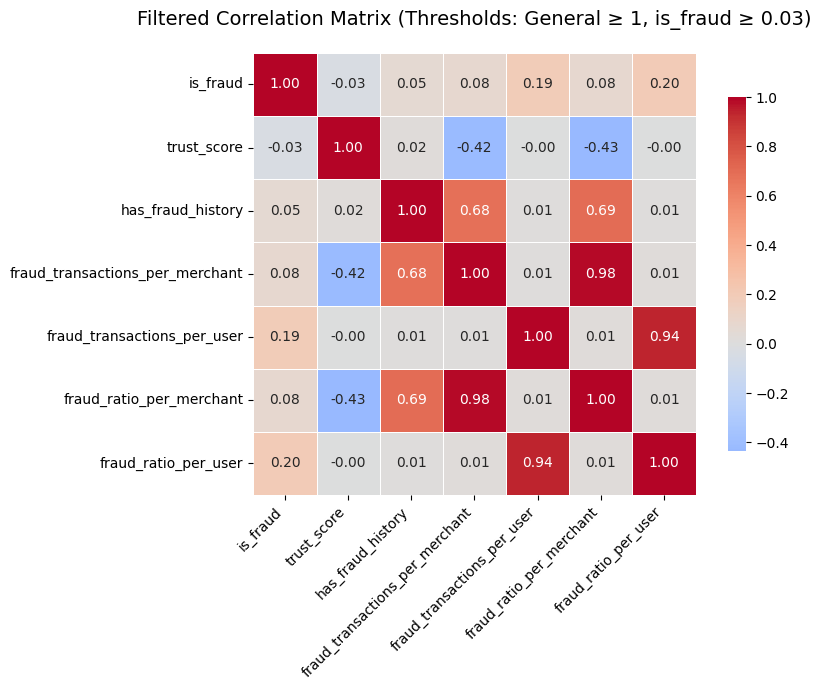

In [56]:
plot_correlation_matrix(full_data, 'is_fraud', 0.03)

In [6]:
# Define lists of categorical and numerical features
categorical_features = [col for col in full_data.columns if full_data[col].dtype == 'bool' 
                        or (col in ['channel', 'education', 'primary_source_of_income', 'sex'])]
# numerical_features = [col for col in full_data.columns if full_data[col].dtype in ['int32', 'int64', 'float64'] 
#                       and col != 'is_fraud']

# Remove duplicates and ensure is_fraud is not in either list
if 'is_fraud' in categorical_features:
    categorical_features.remove('is_fraud')
# if 'is_fraud' in numerical_features:
#     numerical_features.remove('is_fraud')


for feature in categorical_features:
    if feature.startswith('education_') or feature.startswith('sex_') or feature.startswith('primary_income_') or \
       feature.startswith('category_') or feature.startswith('user_country_') or feature.startswith('merchant_country_'):
        chi2_independence(full_data, feature, 'is_fraud')
        print()

# for feature in numerical_features:
#     anova_test(full_data, feature, 'is_fraud')

Chi-square statistic:  1.5628610540247898
p-value:  0.2112467981925032
Degrees of freedom:  1
Expected frequencies: 
sex_Female          False          True 
is_fraud                                
0           307507.129424  150081.870576
1            28500.870576   13910.129424

Chi-square statistic:  9.197740679781668e-05
p-value:  0.9923480172123432
Degrees of freedom:  1
Expected frequencies: 
sex_Male          False          True 
is_fraud                              
0         306015.389284  151573.610716
1          28362.610716   14048.389284

Chi-square statistic:  1.5704603093581744
p-value:  0.21014017822999043
Degrees of freedom:  1
Expected frequencies: 
sex_Other          False          True 
is_fraud                               
0          301655.481292  155933.518708
1           27958.518708   14452.481292

Chi-square statistic:  1.9531341426771593
p-value:  0.1622495169655826
Degrees of freedom:  1
Expected frequencies: 
education_Bachelor         False        True 


unique_countries_count - ANOVA test:
F-statistic: 0.5864
p-value: 0.9308
Statistically significant: No



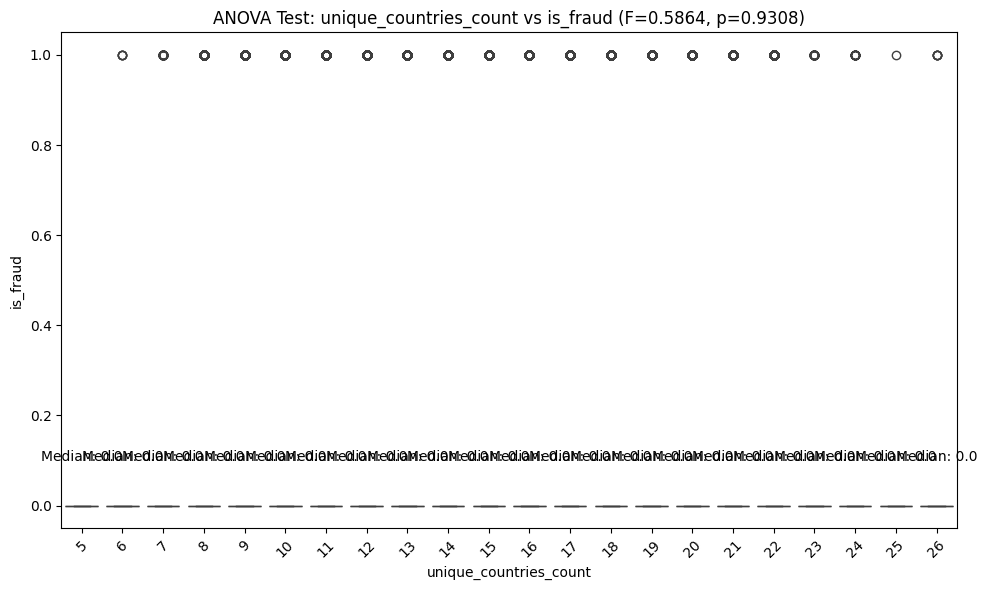



is_common_country - ANOVA test:
F-statistic: 0.0039
p-value: 0.9502
Statistically significant: No



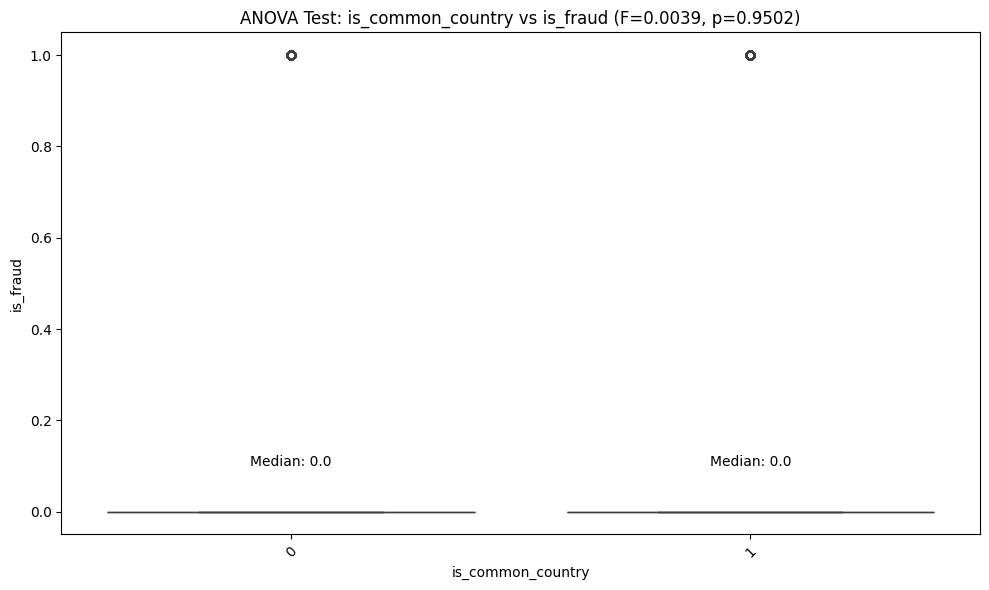

TypeError: At least two samples are required; got 1.

In [ ]:
chuj_features = ['unique_countries_count', 'is_common_country', 'is_new_country', 'txn_count_last_7d']
for feature in chuj_features:
    spearman_correlation(full_data, feature, 'is_fraud')
    print()

In [38]:
output_dir = os.path.join('../..', 'data', 'processed')
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, 'full_data.csv')

full_data.to_csv(output_file, index=False)

print(f"Data saved to {output_file}")

Data saved to ../../data/processed/full_data.csv
